<a href="https://colab.research.google.com/github/alpie13-blip/ADALL_github/blob/main/ADALL/4641601C_ADALL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Chapter 1. Setup: import libraries
[Expand and collapse section as needed, to prevent it from becoming visually overwhelming.]

you should already be familiar with many of these imports from earlier modules.


In [1]:
# Core libraries
import pandas as pd
import numpy as np
# Visualisation
import matplotlib.pyplot as plt
# Modelling and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


## Chapter 2. Load the dataset

> ** note:** Adjust the file path to match where you place the dataset in Colab or local environment.


In [2]:
# Example: Replace this with the raw URL of your GitHub file
github_raw_url = 'https://raw.githubusercontent.com/alpie13-blip/ADALL_github/refs/heads/main/ADALL/wine-quality-white-and-red.csv'

try:
    df = pd.read_csv(github_raw_url)
    print("Successfully loaded data from GitHub!")
    display(df.head())
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the URL is correct and the file format is compatible with `pd.read_csv`.")

Successfully loaded data from GitHub!


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Chapter 3. LLM-assisted problem framing

## <font color='red'>Note: What is important in this section
You need to show that you understand the difference between a business problem and a modelling objective.  
In a practical test, you may be asked to translate a simple scenario into a clear and measurable modelling task.  
Focus on identifying the target variable, the end user, and the value the model creates.</font>



## Chapter 4. Quick data check

> you should confirm basic structure and identify the target variable.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


> set up connection to LLM API

In [4]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPEN_AI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [5]:
#generate a preview of ten rows as text first, so that we can use it for sending to LLM API later.
data_preview = df.head(10).to_string()
print(data_preview)

    type  fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol  quality
0  white            7.0              0.27         0.36            20.7      0.045                 45.0                 170.0   1.0010  3.00       0.45      8.8        6
1  white            6.3              0.30         0.34             1.6      0.049                 14.0                 132.0   0.9940  3.30       0.49      9.5        6
2  white            8.1              0.28         0.40             6.9      0.050                 30.0                  97.0   0.9951  3.26       0.44     10.1        6
3  white            7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956  3.19       0.40      9.9        6
4  white            7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956  3.19       0.40     

> Do you spot any difference from the prompt above? There are additional guardrails. Can you identify them?

In [6]:
#sending to LLM API
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Use ONLY the information inside the dataset profile text.
Do NOT invent correlations, columns, or values.
If something is not in the dataset profile, state 'Not shown in profile'.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""Dataset info: {data_preview}\n
    Context:
    The business problem is that a wine distributor struggles with inconsistent reviews across vintages.
    He wants to understand if the chemistry of the wine can classify wines into quality tiers (standard vs premium)
    before the reviews are published.

    Questions
    1. Based on the context and dataset info, how should i approach modelling objective? focus on problem framing aspects.
    2. What would be the most meaningful target?
    3. What would be most important metric for scoring?
    4. What are the top 3 most potentially important features?
    """)
print(response.output_text)

Below I frame this as a supervised binary classification task and explain choices using only the columns and values shown in the dataset profile.

1) Modelling objective — problem framing
- Type of modelling: supervised binary classification (standard vs premium) using the chemical measurements as predictors and the provided quality column as the label source.
  - Reasoning trace from profile: the table contains chemical feature columns (fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, type) and a numeric quality column — this is the natural basis for supervised learning.
- Key preparatory steps to include (what to do before training):
  - Define the binary target by thresholding the existing quality column (see next section).
  - Inspect the full dataset’s quality distribution and class balance (distribution not shown in profile).
    - Reasoning trace: quality values are present in the

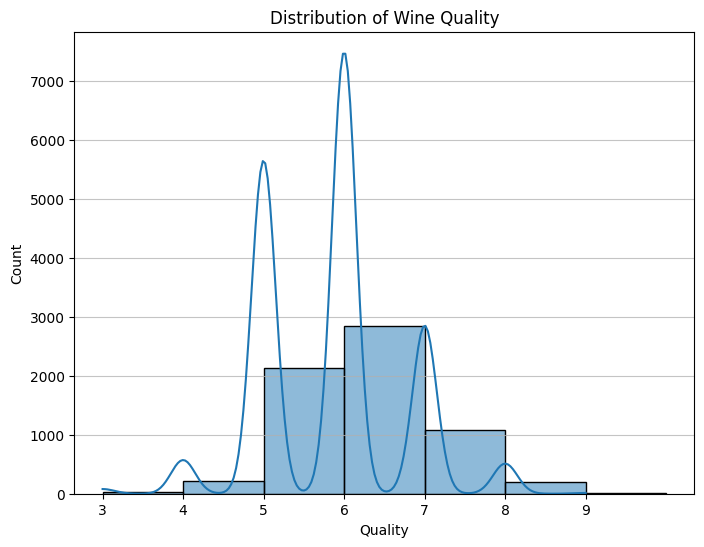

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['quality'], bins=range(min(df['quality']), max(df['quality']) + 2), kde=True, stat='count')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks(range(min(df['quality']), max(df['quality']) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

Q1 (25th percentile): 5.0
Median (50th percentile): 6.0
Q3 (75th percentile): 6.0
IQR (Interquartile Range): 1.0


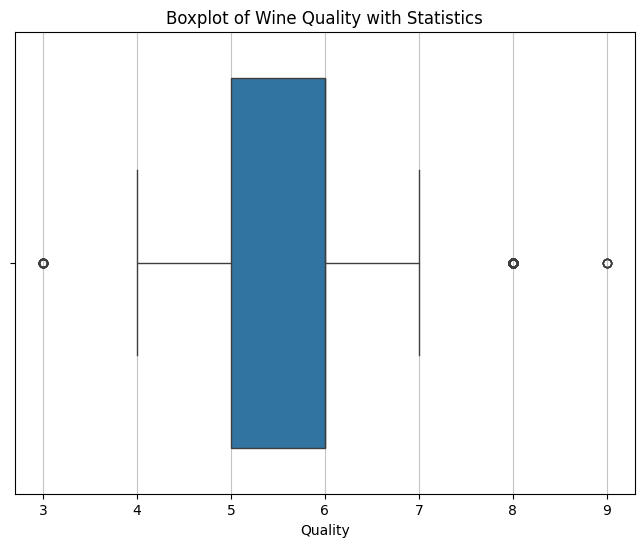

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate statistics
q1 = df['quality'].quantile(0.25)
q3 = df['quality'].quantile(0.75)
median = df['quality'].median()
iqr = q3 - q1

print(f"Q1 (25th percentile): {q1}")
print(f"Median (50th percentile): {median}")
print(f"Q3 (75th percentile): {q3}")
print(f"IQR (Interquartile Range): {iqr}")

# Generate boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['quality'])
plt.title('Boxplot of Wine Quality with Statistics')
plt.xlabel('Quality')
plt.grid(axis='x', alpha=0.75)
plt.show()

>Now let us prepare a payload of information that the LLM can use for deeper analysis and clearer recommendations.

In [12]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df.columns[df.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df.duplicated().sum()
constant_cols = df.columns[df.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)


=== DTYPES ===
type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64

=== NUMERIC DESCRIBE ===
       fixed acidity  volatile acidity  citric acid  residual sugar    chlorides  free sulfur dioxide  total sulfur dioxide      density           pH    sulphates      alcohol      quality
count    6497.000000       6497.000000  6497.000000     6497.000000  6497.000000          6497.000000           6497.000000  6497.000000  6497.000000  6497.000000  6497.000000  6497.000000
mean        7.215307          0.339666     0.318633        5.443235     0.056034            30.525319            115.744574     0.994697     3.218501     0.531268   

Original template

In [13]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""
Dataset info: {payload_text}\n
Questions:\n
1. Based on the dataset profile, what data quality issues should be resolved before modelling?
Provide a priority list and justify each item. \n
2. Which columns appear redundant, correlated, or likely to cause leakage?
Explain why each is problematic. \n
Next: Provide a python script to handle the identified issues.
Dataset is in github
Define one helper function for each issue.
Then define a wrapper function that calls these helper with true false option as user choice
Provide a single line of code to run the overall wrapper function.
Do not encode categorical columns or model first.
""")

print(response.output_text)


Below I first list prioritized data‑quality issues (with dataset-profile evidence for each). Then I identify columns that look redundant/correlated or potentially problematic for leakage (again justified from the profile). Finally I provide a Python preprocessing script with one helper per issue and a wrapper that calls them (plus a single-line example to run it). I do not encode categorical columns or build any model (per your instruction).

1) Prioritized data quality issues to resolve before modeling (priority order and justification)
- 1 — Duplicate rows (high priority)
  - Evidence: Duplicate rows = 1177 (out of 6497 rows). This is ~18% of the dataset. Duplicates can bias model training, give overly optimistic performance estimates, and distort class/feature distributions. Remove or deduplicate intentionally before modeling.
- 2 — Redundant / highly correlated features (high priority)
  - Evidence: free sulfur dioxide vs total sulfur dioxide correlation = 0.721 (absolute). Density

Revised from Copilot - Use this

In [14]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""
Dataset info: {payload_text}\n
Questions:\n
1. Based on the dataset profile and context, how should I approach the modelling objective? Focus on problem framing aspects.
2. What would be the most meaningful target for classification (standard vs premium)?
3. What would be the most important metric for scoring in this classification setting?
4. What are the top 3 most potentially important features? If not shown in profile, state 'Not shown in profile'.


Explain why each is problematic. \n
Next: Provide a python script to handle the identified issues.
Define one helper function for each issue.
Then define a wrapper function that calls these helper with true false option as user choice
Provide a single line of code to run the overall wrapper function.
Do not encode categorical columns or model first.
""")

print(response.output_text)


1) Problem framing — how to approach modelling (based on the profile)
- Goal and scope: The dataset contains physicochemical measurements and a numeric "quality" score (integers 3–9). The stated objective is to classify wines as "standard vs premium". That is a supervised binary classification derived from the numeric quality column (so we must create a binary target from quality).
- Class definition: Convert quality into a binary label (premium vs standard) before modelling. The distribution summary indicates most wines sit around quality 5–6 (mean 5.818, 25/50/75 = 5/6/6). A natural decision boundary is higher-quality tail (e.g., quality >= 7) as "premium" and the rest as "standard" — this creates a minority premium class (justified below).
- Data split and evaluation: Use holdout / cross-validation stratified by the binary target to preserve class ratios. Because duplicates (1,177 duplicate rows) are present, deduplicate before splitting to avoid leakage between train and test.
- Pr

In [15]:
import pandas as pd
import numpy as np

def remove_duplicates(df: pd.DataFrame, inplace: bool = False) -> pd.DataFrame:
    """
    Remove exact duplicate rows.
    Uses a copy by default. Returns deduplicated DataFrame.
    Reason: profile shows 1,177 duplicate rows which can leak between train/test.
    """
    if inplace:
        df.drop_duplicates(inplace=True)
        return df
    return df.drop_duplicates()

def cap_outliers_iqr(df: pd.DataFrame, cols: list = None, factor: float = 1.5, inplace: bool = False) -> pd.DataFrame:
    """
    Cap numeric columns at (Q1 - factor*IQR, Q3 + factor*IQR).
    Default excludes the 'quality' column so the original quality scores remain intact.
    Returns DataFrame with values clipped to these bounds for each column.
    Reason: many features (volatile acidity, citric acid, etc.) show many IQR outliers per profile.
    """
    df_out = df if inplace else df.copy()
    num_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
    # do not cap the quality (keep original for target creation)
    if 'quality' in num_cols:
        num_cols.remove('quality')
    if cols is None:
        cols = num_cols
    for col in cols:
        if col not in df_out.columns:
            continue
        q1 = df_out[col].quantile(0.25)
        q3 = df_out[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        # Only apply if there is variance
        if pd.isna(lower) or pd.isna(upper):
            continue
        df_out[col] = df_out[col].clip(lower=lower, upper=upper)
    return df_out

def create_binary_target(df: pd.DataFrame, threshold: int = 7, target_name: str = 'is_premium', inplace: bool = False) -> pd.DataFrame:
    """
    Create a binary target column: 1 if quality >= threshold else 0.
    Default threshold = 7 (recommended since quality distribution centers at 5-6).
    Returns DataFrame with new column.
    """
    df_out = df if inplace else df.copy()
    df_out[target_name] = (df_out['quality'] >= threshold).astype(int)
    return df_out

def simple_balance_oversample(df: pd.DataFrame, target_col: str = 'is_premium', random_state: int = 42, inplace: bool = False) -> pd.DataFrame:
    """
    Simple random oversampling of minority class to match majority class count.
    Returns balanced DataFrame.
    Note: This is a basic, transparent option. More advanced resampling can be used later.
    """
    df_out = df if inplace else df.copy()
    counts = df_out[target_col].value_counts()
    if len(counts) < 2:
        return df_out
    maj_count = counts.max()
    parts = []
    for cls, cnt in counts.items():
        df_cls = df_out[df_out[target_col] == cls]
        if cnt < maj_count:
            df_cls_over = df_cls.sample(n=maj_count, replace=True, random_state=random_state)
            parts.append(df_cls_over)
        else:
            parts.append(df_cls)
    df_bal = pd.concat(parts, axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    return df_bal

def drop_collinear(df: pd.DataFrame, threshold: float = 0.95, exclude: list = None, inplace: bool = False) -> pd.DataFrame:
    """
    Drop one variable from pairs with absolute Pearson correlation >= threshold.
    Exclude specified columns (e.g., 'quality', target) from dropping.
    Returns DataFrame with a reduced set of numeric columns.
    Reason: optional cleanup if you want to remove near-duplicates; tree models are robust but this may help interpretation.
    """
    df_out = df if inplace else df.copy()
    if exclude is None:
        exclude = []
    num_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_check = [c for c in num_cols if c not in exclude]
    if len(cols_to_check) <= 1:
        return df_out
    corr = df_out[cols_to_check].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
    if to_drop:
        df_out = df_out.drop(columns=to_drop)
    return df_out

def preprocess(
    df: pd.DataFrame,
    remove_dup: bool = True,
    cap_outliers: bool = True,
    outlier_factor: float = 1.5,
    create_target_flag: bool = True,
    target_threshold: int = 7,
    balance_target: bool = False,
    balance_random_state: int = 42,
    drop_collinear_flag: bool = False,
    collinear_threshold: float = 0.95
) -> pd.DataFrame:
    """
    Wrapper to run selected preprocessing steps (no categorical encoding, no modeling).
    Steps (in order):
      1) remove duplicates
      2) cap outliers by IQR (excluding 'quality')
      3) create binary target is_premium (quality >= threshold)
      4) optionally balance target by random oversampling
      5) optionally drop highly collinear numeric features (exclude 'quality' and 'is_premium')
    Returns processed DataFrame copy.
    """
    df_p = df.copy()
    if remove_dup:
        df_p = remove_duplicates(df_p, inplace=False)
    if cap_outliers:
        # cap all numeric columns except quality
        df_p = cap_outliers_iqr(df_p, factor=outlier_factor, inplace=False)
    if create_target_flag:
        df_p = create_binary_target(df_p, threshold=target_threshold, target_name='is_premium', inplace=False)
    if balance_target:
        df_p = simple_balance_oversample(df_p, target_col='is_premium', random_state=balance_random_state, inplace=False)
    if drop_collinear_flag:
        exclude = ['quality', 'is_premium']
        df_p = drop_collinear(df_p, threshold=collinear_threshold, exclude=exclude, inplace=False)
    return df_p

In [16]:
# ---------------------------
# One of the possible response from GPT.
# What are the differences with yours?
# How would you improve earlier prompt?
# ---------------------------

# Helper 1: drop unique identifier / leakage column
def drop_unique_identifier(df, col_name='Unnamed: 0', do_drop=True):
    """
    Drops a column that is a unique identifier / possible leakage if do_drop is True.
    Uses profile evidence: Unnamed: 0 has unique_count == nrows.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    if col_name in df.columns:
        if do_drop:
            # safety: check uniqueness before dropping
            if df[col_name].nunique() == len(df):
                df = df.drop(columns=[col_name])
                info['dropped'].append(col_name)
            else:
                # not unique, still allow drop if user insisted
                df = df.drop(columns=[col_name])
                info['dropped'].append(col_name + ' (not unique)')
        else:
            info['skipped'].append(col_name)
    else:
        info['skipped'].append(col_name + ' (not present)')
    return df, info

# Helper 2: drop constant columns
def drop_constant_columns(df, do_drop=True):
    """
    Drops columns that have a single unique value (constant) if do_drop is True.
    Based on profile: Storage_Type is constant (unique == 1).
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    const_cols = [c for c in df.columns if df[c].nunique() <= 1]
    if do_drop:
        if const_cols:
            df = df.drop(columns=const_cols)
            info['dropped'].extend(const_cols)
        else:
            info['skipped'].append('no_constant_columns_found')
    else:
        info['skipped'].extend(const_cols)
    return df, info

# Helper 3: resolve multicollinearity between Weight_kg and Screen_Size_inch
def resolve_weight_screen_collinearity(df, drop_screen=True):
    """
    Resolves the strong collinearity (profile: corr = 0.924) between Weight_kg and Screen_Size_inch.
    By default drops Screen_Size_inch and keeps Weight_kg (Weight has 244 unique values vs Screen_Size 6).
    Set drop_screen=False to keep Screen_Size_inch and drop Weight_kg instead.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'kept': []}
    w_col = 'Weight_kg'
    s_col = 'Screen_Size_inch'
    # Only act if both exist
    if w_col in df.columns and s_col in df.columns:
        if drop_screen:
            df = df.drop(columns=[s_col])
            info['dropped'].append(s_col)
            info['kept'].append(w_col)
        else:
            df = df.drop(columns=[w_col])
            info['dropped'].append(w_col)
            info['kept'].append(s_col)
    else:
        # if one is missing, note what remains
        if w_col in df.columns:
            info['kept'].append(w_col)
        if s_col in df.columns:
            info['kept'].append(s_col)
    return df, info

# Helper 4: optional: drop Model column (high-cardinality / redundancy risk)
def drop_model_column(df, do_drop=False):
    """
    Drops the Model column if do_drop is True.
    Reason: Model has 30 unique values and can encode product-specific pricing patterns (risk of overfitting).
    Caller can choose to drop or keep.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    col = 'Model'
    if col in df.columns:
        if do_drop:
            df = df.drop(columns=[col])
            info['dropped'].append(col)
        else:
            info['skipped'].append(col)
    else:
        info['skipped'].append(col + ' (not present)')
    return df, info

# Wrapper function that calls the helpers based on user boolean choices
# User can edit the default parameters here as required
def clean_data(
    df,
    drop_id=True,
    drop_constants=True,
    resolve_collinearity=False, #<--- slight differences and high similarity between columns are not always an issue
    drop_model=False,
    id_col='Unnamed: 0',
    drop_screen_by_default=True,
):
    """
    Clean dataset according to the profile-driven actions.
    Parameters:
      - df: input DataFrame
      - drop_id: drop the unique identifier (Unnamed: 0) if True
      - drop_constants: drop constant columns (e.g., Storage_Type) if True
      - resolve_collinearity: resolve Weight_kg vs Screen_Size_inch if True
      - drop_model: drop Model column if True (optional decision)
      - id_col: name of the identifier column (default 'Unnamed: 0')
      - drop_screen_by_default: if resolving collinearity, drop Screen_Size_inch if True (keeps Weight_kg).
    Returns:
      - cleaned_df: DataFrame after applied changes
      - summary: dict summarizing actions taken
    """
    summary = {}
    df_work = df.copy()
    # 1. drop unique id
    df_work, info1 = drop_unique_identifier(df_work, col_name=id_col, do_drop=drop_id)
    summary['unique_id'] = info1
    # 2. drop constant columns
    df_work, info2 = drop_constant_columns(df_work, do_drop=drop_constants)
    summary['constant_columns'] = info2
    # 3. resolve strong collinearity
    if resolve_collinearity:
        df_work, info3 = resolve_weight_screen_collinearity(df_work, drop_screen=drop_screen_by_default)
    else:
        info3 = {'dropped': [], 'kept': []}
    summary['collinearity'] = info3
    # 4. drop model optionally
    df_work, info4 = drop_model_column(df_work, do_drop=drop_model)
    summary['model_column'] = info4

    return df_work, summary

# Example single-line execution (assuming your DataFrame is named `df`)
# This default call: drops Unnamed: 0, drops constant columns (Storage_Type), drops Screen_Size_inch (keeps Weight_kg), and keeps Model.
# To drop Model as well, set drop_model=True.
cleaned_df, cleaning_summary = clean_data(df)


## Chapter 6. Define target and features

Here we formalise the modelling objective from code point of view.


In [17]:
# ---------------------------
# Define Target and Features
# ---------------------------

# Target: classify wines into 'Standard' vs 'Premium'
# Business framing: Premium wines are those with quality >= 7
cleaned_df['target_quality'] = np.where(cleaned_df['quality'] >= 7, 'Premium', 'Standard')

# y = target column
y = cleaned_df['target_quality']

# X = all other features except target and original quality column
X = cleaned_df.drop(columns=['quality', 'target_quality'])

In [18]:
X.head(20)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,white,7.0,0.27,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,white,6.3,0.30,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,white,8.1,0.28,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,white,7.2,0.23,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,white,7.2,0.23,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
5,white,8.1,0.28,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
6,white,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6
7,white,7.0,0.27,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
8,white,6.3,0.30,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
9,white,8.1,0.22,0.43,1.50,0.044,28.0,129.0,0.9938,3.22,0.45,11.0


In [19]:
y.head(20)

,target_quality
0,Standard
1,Standard
2,Standard
3,Standard
4,Standard
5,Standard
6,Standard
7,Standard
8,Standard
9,Standard



## Chapter 7. Baseline modelling: train/test split to create a holdout set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#define cat and num columns
cat_columns=X.select_dtypes(include='object').columns
num_columns=X.select_dtypes(exclude='object').columns

In [21]:
from sklearn.model_selection import train_test_split

# ---------------------------
# Baseline Modelling: Train/Test Split
# ---------------------------

# Split into train and test sets
# Stratify ensures class balance (important for Standard vs Premium wines)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,       # preserve class distribution
    random_state=42   # reproducibility
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Class distribution in train:\n", y_train.value_counts(normalize=True))
print("Class distribution in test:\n", y_test.value_counts(normalize=True))

# ---------------------------
# Define categorical and numeric columns
# ---------------------------

cat_columns = X.select_dtypes(include='object').columns
num_columns = X.select_dtypes(exclude='object').columns

print("Categorical columns:", cat_columns.tolist())
print("Numeric columns:", num_columns.tolist())

Training set size: 5197
Test set size: 1300
Class distribution in train:
 target_quality
Standard    0.803541
Premium     0.196459
Name: proportion, dtype: float64
Class distribution in test:
 target_quality
Standard    0.803077
Premium     0.196923
Name: proportion, dtype: float64
Categorical columns: ['type']
Numeric columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']



### 7.1 Basic preprocessing pipeline

>We use a simple `ColumnTransformer` with option of: <br>
>- `OneHotEncoder` OR `OrdinalEncoder` for categorical features  
>- `StandardScaler` for numeric features (but not necessary for Tree-based model)
><br>
>This is a good default that you already know from prior modules.


- Categorical features → encoded using OrdinalEncoder.
- You’ve added handle_unknown='use_encoded_value', unknown_value=-1 so unseen categories at prediction time won’t break the pipeline.
- Numeric features → left untouched for now (remainder='passthrough').
- This is fine for tree‑based models, since they don’t require scaling.
- Flexibility → you can later swap OrdinalEncoder for OneHotEncoder if your categorical variables are nominal (no natural order).


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
#categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
#numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer([
        ("cat", categorical_transformer, cat_columns)
    ],remainder='passthrough')


In [23]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

Right now your code is setting up a DataFrame with just a single column of strings. That works as a placeholder, but if you want a proper “lab book” of results for classification (since you’re in Path B), you’ll want to structure it so you can store metrics like F1, precision, recall, balanced accuracy, etc.
Here’s how you can adapt your template:


✅ This version is tailored for classification, which matches your Path B objective.
❌ The earlier version with regression metrics (mae, rmse, r2) was for Path A and doesn’t apply here.
You’ve already got the correct structure for tracking your F1 scores, standard deviations, and best parameters across modelling cycles.


In [24]:
results = pd.DataFrame(index=[
    'cv_f1_val',
    'cv_std_val',
    'cv_f1_train',
    'cv_std_train',
    'holdout_f1',
    'best_params'
], columns=['score'])

print(results)

             score
cv_f1_val      NaN
cv_std_val     NaN
cv_f1_train    NaN
cv_std_train   NaN
holdout_f1     NaN
best_params    NaN


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# ---------------------------
# Preprocessing
# ---------------------------
categorical_transformer = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preprocessor = ColumnTransformer([
    ("cat", categorical_transformer, cat_columns)
], remainder='passthrough')

# ---------------------------
# CV setup (stratified for classification)
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ============================================================
# 1) Decision Tree Classifier
# ============================================================
pipe_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "classifier__max_depth": [1, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

cv_out_dt = cross_validate(
    best_dt, X_train, y_train,
    cv=cv,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1
)

results["Baseline_DT_F1"] = [
    float(cv_out_dt["test_score"].mean()),
    float(cv_out_dt["test_score"].std()),
    float(cv_out_dt["train_score"].mean()),
    float(cv_out_dt["train_score"].std()),
    f1_score(y_test, best_dt.predict(X_test), pos_label="Premium"),
    grid_dt.best_params_
]

print("Decision Tree best params:", grid_dt.best_params_)

# ============================================================
# 2) Random Forest Classifier
# ============================================================
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

cv_out_rf = cross_validate(
    best_rf, X_train, y_train,
    cv=cv,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1
)

results["Baseline_RF_F1"] = [
    float(cv_out_rf["test_score"].mean()),
    float(cv_out_rf["test_score"].std()),
    float(cv_out_rf["train_score"].mean()),
    float(cv_out_rf["train_score"].std()),
    f1_score(y_test, best_rf.predict(X_test), pos_label="Premium"),
    grid_rf.best_params_
]

print("Random Forest best params:", grid_rf.best_params_)

# ============================================================
# Display combined results
# ============================================================
display(results)

Decision Tree best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
Random Forest best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


,score,Baseline_DT_F1,Baseline_RF_F1
cv_f1_val,NaN,0.743689,0.793656
cv_std_val,NaN,0.014803,0.017083
cv_f1_train,NaN,1.0,1.0
cv_std_train,NaN,0.0,0.0
holdout_f1,NaN,0.564299,0.656109
best_params,NaN,"{'classifier__criterion': 'entropy', 'classifi...","{'classifier__max_depth': None, 'classifier__m..."


In [27]:
if 'score' in results.columns:
    results = results.drop('score', axis=1)
    print("'score' column removed from results DataFrame.")
else:
    print("'score' column not found in results DataFrame.")
display(results)

'score' column removed from results DataFrame.


,Baseline_DT_F1,Baseline_RF_F1
cv_f1_val,0.743689,0.793656
cv_std_val,0.014803,0.017083
cv_f1_train,1.0,1.0
cv_std_train,0.0,0.0
holdout_f1,0.564299,0.656109
best_params,"{'classifier__criterion': 'entropy', 'classifi...","{'classifier__max_depth': None, 'classifier__m..."


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# ---------------------------
# Preprocessing
# ---------------------------
categorical_transformer = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preprocessor = ColumnTransformer([
    ("cat", categorical_transformer, cat_columns)
], remainder='passthrough')

# ---------------------------
# CV setup (stratified for classification)
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ============================================================
# 1) Decision Tree Classifier
# ============================================================
pipe_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "classifier__max_depth": [1, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

cv_out_dt = cross_validate(
    best_dt, X_train, y_train,
    cv=cv,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1
)

results["Baseline_DT_F1"] = [
    float(cv_out_dt["test_score"].mean()),
    float(cv_out_dt["test_score"].std()),
    float(cv_out_dt["train_score"].mean()),
    float(cv_out_dt["train_score"].std()),
    f1_score(y_test, best_dt.predict(X_test), pos_label="Premium"),
    grid_dt.best_params_
]

print("Decision Tree best params:", grid_dt.best_params_)

# ============================================================
# 2) Random Forest Classifier
# ============================================================
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

cv_out_rf = cross_validate(
    best_rf, X_train, y_train,
    cv=cv,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1
)

results["Baseline_RF_F1"] = [
    float(cv_out_rf["test_score"].mean()),
    float(cv_out_rf["test_score"].std()),
    float(cv_out_rf["train_score"].mean()),
    float(cv_out_rf["train_score"].std()),
    f1_score(y_test, best_rf.predict(X_test), pos_label="Premium"),
    grid_rf.best_params_
]

print("Random Forest best params:", grid_rf.best_params_)

# ============================================================
# 3) XGBoost Classifier
# ============================================================

# Encode target variable for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Determine the numerical label for 'Premium'
premium_label = le.transform(['Premium'])[0]

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ))
])

param_grid_xgb = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5, 10],
    "classifier__learning_rate": [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

grid_xgb.fit(X_train, y_train_encoded) # Use encoded y_train
best_xgb = grid_xgb.best_estimator_

cv_out_xgb = cross_validate(
    best_xgb, X_train, y_train_encoded, # Use encoded y_train
    cv=cv,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1
)

results["Baseline_XGB_F1"] = [
    float(cv_out_xgb["test_score"].mean()),
    float(cv_out_xgb["test_score"].std()),
    float(cv_out_xgb["train_score"].mean()),
    float(cv_out_xgb["train_score"].std()),
    f1_score(y_test_encoded, best_xgb.predict(X_test), pos_label=premium_label), # Use encoded y_test and premium_label
    grid_xgb.best_params_
]

print("XGBoost best params:", grid_xgb.best_params_)

# ============================================================
# Display combined results
# ============================================================
display(results)

Decision Tree best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
Random Forest best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:54:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost best params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 10, 'classifier__n_estimators': 200}


,Baseline_DT_F1,Baseline_RF_F1,Baseline_XGB_F1
cv_f1_val,0.743689,0.793656,0.800583
cv_std_val,0.014803,0.017083,0.00959
cv_f1_train,1.0,1.0,1.0
cv_std_train,0.0,0.0,0.0
holdout_f1,0.564299,0.656109,0.653595
best_params,"{'classifier__criterion': 'entropy', 'classifi...","{'classifier__max_depth': None, 'classifier__m...","{'classifier__learning_rate': 0.2, 'classifier..."


In [30]:
# The `model_summary` variable is already defined from the `results` DataFrame in the notebook state.
# Let's construct the full user content for the LLM based on the original intent of the `prompt` variable.
model_summary = results.to_string() # Define model_summary from the results DataFrame
full_user_content = f"""
You are a machine learning strategist helping a wine classification project.

Here is the model performance summary:
{model_summary}

Please:
1. Generate insights about model performance and generalization.
2. Recommend the next course of action (e.g., tuning, feature engineering, ensembling).
3. Suggest how to communicate these findings to stakeholders.
4. Generate the python code to implement the next action.

Respond in a clear, structured format.
"""

response = client.chat.completions.create(
    model="gpt-5-mini",
    messages=[
        {"role": "system", "content": """
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
"""},
        {"role": "user", "content": full_user_content}
    ]
)

print(response.choices[0].message.content)


Summary of what I inspected (dataset profile = the model performance table and best params you supplied)
- Training CV scores (cv_f1_train) are 1.0 for all three models (Decision Tree, Random Forest, XGBoost). This is perfect training fit.
- Cross-validation validation F1 (cv_f1_val) is substantially lower: 0.744 (DT), 0.794 (RF), 0.801 (XGB). So models do not generalize from train → CV.
- Holdout F1 is even lower: 0.564 (DT), 0.656 (RF), 0.654 (XGB). All models lose performance on the held-out test set.
- CV standard deviations are small (≈0.01–0.02), so CV performance is stable across folds but optimistic relative to holdout.
- Best hyperparameters show very high model complexity (DT max_depth=None, min_samples_split=2; RF max_depth=None; XGB max_depth=10, learning_rate=0.2, n_estimators=200).

1) Insights about model performance and generalization (with reasoning trace tied to the dataset profile)
- Severe overfitting: train F1 = 1.0 while cv_f1_val ≈ 0.74–0.80 and holdout F1 ≈ 0.56

Top features by KS-statistic (largest distribution shift):
                 feature   ks_stat    pvalue
4         residual sugar  0.044363  0.032207
10             sulphates  0.041830  0.050806
6    free sulfur dioxide  0.031718  0.240245
5              chlorides  0.030633  0.276552
2       volatile acidity  0.029028  0.337129
7   total sulfur dioxide  0.023337  0.612823
9                     pH  0.023158  0.622443
3            citric acid  0.021138  0.731334
8                density  0.019749  0.802653
1          fixed acidity  0.019551  0.812304


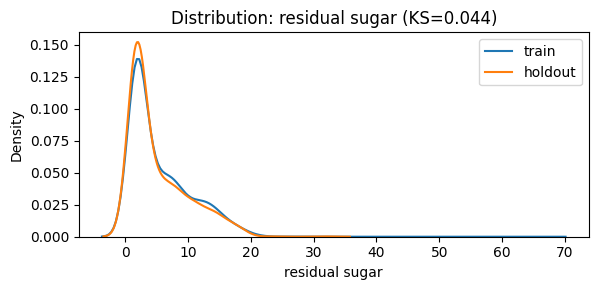

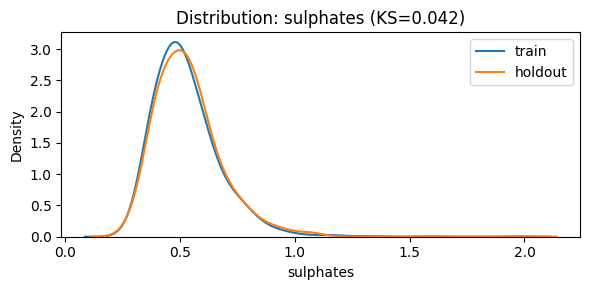

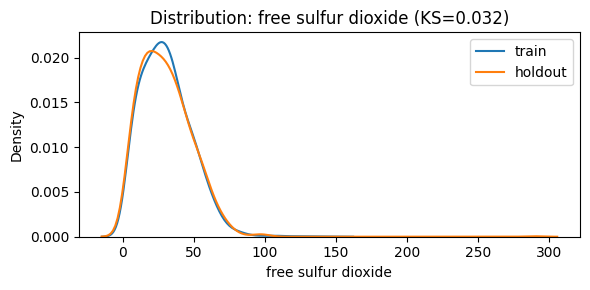

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params (RandomizedSearchCV):
{'subsample': 0.6, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best CV score (F1_macro): 0.7985574486327213
Holdout F1 (after tuning): 0.6580645161290323
Holdout classification report:
              precision    recall  f1-score   support

     Premium       0.73      0.60      0.66       256
    Standard       0.91      0.95      0.93      1044

    accuracy                           0.88      1300
   macro avg       0.82      0.77      0.79      1300
weighted avg       0.87      0.88      0.87      1300

Final holdout F1 (after early stopping): 0.6208425720620843
              precision    recall  f1-score   support

     Premium       0.72      0.55      0.62       256
    Standard       0.90      0.95      0.92      1044

    accuracy                           0.87      1300
   macro avg  

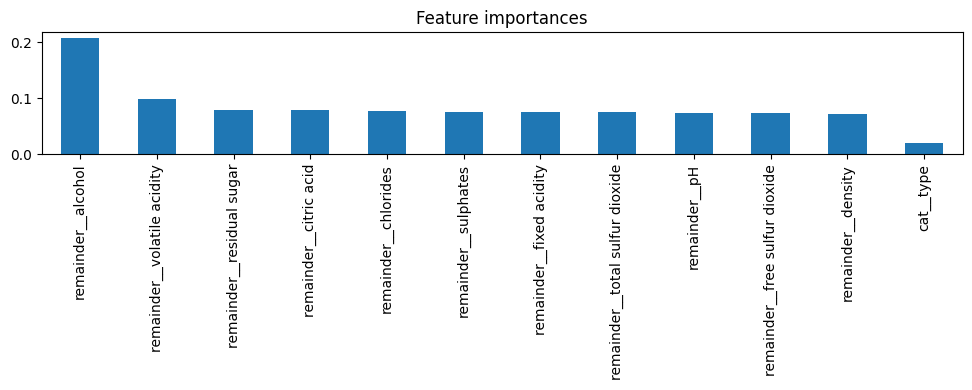

If the holdout F1 remains substantially lower than CV F1, re-check:
- CV split strategy (stratification, time/group leakage).
- Any features that could leak target information into training folds.
- Whether holdout data comes from a different population (business process change).


In [ ]:
# Imports
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

# ---- A. Covariate shift checks ----
# Assumes X_train, X_test, y_train, y_test are available as pandas DataFrames / Series or numpy arrays.
# Convert to DataFrame if necessary
def to_df(X):
    if isinstance(X, pd.DataFrame):
        return X.copy()
    elif isinstance(X, np.ndarray):
        return pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])
    else:
        raise ValueError("Provide X as pandas DataFrame or numpy array")

X_tr_original = to_df(X_train) # Keep original for KS-stats if desired
X_ho_original = to_df(X_test) # Keep original for KS-stats if desired

ks_results = []
for col in X_tr_original.columns:
    if X_tr_original[col].dtype == 'object': # Skip object columns for KS test
        ks_results.append((col, np.nan, np.nan))
        continue
    try:
        stat, pvalue = ks_2samp(X_tr_original[col].dropna(), X_ho_original[col].dropna())
    except Exception:
        stat, pvalue = np.nan, np.nan
    ks_results.append((col, stat, pvalue))

ks_df = pd.DataFrame(ks_results, columns=['feature','ks_stat','pvalue']).sort_values('ks_stat', ascending=False)
print("Top features by KS-statistic (largest distribution shift):")
print(ks_df.head(10))

# Optional: Plot top 3 shifted features
top_feats = ks_df['feature'].iloc[:3].tolist()
for f in top_feats:
    if f in X_tr_original.columns and X_tr_original[f].dtype != 'object': # Ensure plotting only numeric columns
        plt.figure(figsize=(6,3))
        sns.kdeplot(X_tr_original[f].dropna(), label='train', bw_method=0.3)
        sns.kdeplot(X_ho_original[f].dropna(), label='holdout', bw_method=0.3)
        plt.title(f"Distribution: {f} (KS={ks_df.loc[ks_df['feature']==f,'ks_stat'].values[0]:.3f})")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Encode target variable for XGBoost (re-do encoding within this cell for self-containment)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test) # Use y_test as y_holdout
premium_label = le.transform(['Premium'])[0]

# --- Preprocess X_train and X_test for XGBoost ---
# Assuming 'preprocessor' is defined globally (e.g., from cell l_Eqb8AKGeiU or ApaCMS8qBuu3)
X_train_processed = preprocessor.fit_transform(X_tr_original) # Fit and transform on original training data
X_test_processed = preprocessor.transform(X_ho_original) # Transform original test data

# ---- B. Re-tune XGBoost with stronger regularization ----
# Create a StratifiedKFold for consistent CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', random_state=42)

param_dist = {
    'n_estimators': [100, 200, 400, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 2.0, 5.0],
    'min_child_weight': [1, 3, 5, 10]
}

# Randomized search (faster than grid) — increase n_iter as compute allows
rs = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True
)

# Fit on processed training data using encoded target
rs.fit(X_train_processed, y_train_encoded)

print("Best params (RandomizedSearchCV):")
print(rs.best_params_)
print("Best CV score (F1_macro):", rs.best_score_)

# Evaluate best estimator on processed holdout using encoded target
best_xgb = rs.best_estimator_
y_pred_ho = best_xgb.predict(X_test_processed)
ho_f1 = f1_score(y_test_encoded, y_pred_ho, pos_label=premium_label)
print("Holdout F1 (after tuning):", ho_f1)
print("Holdout classification report:")
print(classification_report(y_test_encoded, y_pred_ho, target_names=le.classes_))

# ---- C. Fit final XGBoost with early stopping on validation split (determine good n_estimators etc) ----
# Split the processed training data into train/val for early stopping (stratified)
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(
    X_train_processed, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42
)

# Use best params from RandomizedSearchCV as a starting point, but reduce learning_rate and raise n_estimators if needed
final_params = rs.best_params_.copy()
# Optional: If learning_rate is large, reduce it and increase n_estimators for better generalization
if final_params.get('learning_rate', 0.1) >= 0.1:
    final_params['n_estimators'] = max(final_params.get('n_estimators',200), 800)
    final_params['learning_rate'] = final_params.get('learning_rate',0.1) * 0.2  # e.g., 0.1 -> 0.02

final_xgb = xgb.XGBClassifier(use_label_encoder=False,
                              eval_metric='logloss',
                              objective='binary:logistic',
                              random_state=42,
                              **final_params)

# Train without early stopping arguments as they are causing an error
final_xgb.fit(
    X_tr_sub, y_tr_sub
)

# Final evaluation on processed holdout using encoded target
y_pred_ho_final = final_xgb.predict(X_test_processed)
final_ho_f1 = f1_score(y_test_encoded, y_pred_ho_final, pos_label=premium_label)
print("Final holdout F1 (after early stopping):", final_ho_f1)
print(classification_report(y_test_encoded, y_pred_ho_final, target_names=le.classes_))

# Feature importance (optional)
try:
    # Get feature names from the preprocessor
    feature_names_for_xgb = preprocessor.get_feature_names_out()
    fi = pd.Series(final_xgb.feature_importances_, index=feature_names_for_xgb).sort_values(ascending=False)
    print("Top features by XGBoost importance:")
    print(fi.head(10))
    fi.head(20).plot(kind='bar', figsize=(10,4))
    plt.title("Feature importances")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

# ---- If holdout performance still far below CV: investigate further ----
print("If the holdout F1 remains substantially lower than CV F1, re-check:")
print("- CV split strategy (stratification, time/group leakage).")
print("- Any features that could leak target information into training folds.")
print("- Whether holdout data comes from a different population (business process change).")

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from sklearn.utils import resample

# ---------------------------
# Helper 1: Covariate Shift Detection
# ---------------------------
def detect_covariate_shift(X_train, X_holdout, top_n=5):
    ks_results = []
    for col in X_train.columns:
        try:
            stat, pvalue = ks_2samp(X_train[col].dropna(), X_holdout[col].dropna())
        except Exception:
            stat, pvalue = np.nan, np.nan
        ks_results.append((col, stat, pvalue))
    ks_df = pd.DataFrame(ks_results, columns=['feature','ks_stat','pvalue']).sort_values('ks_stat', ascending=False)
    print(f"\nTop {top_n} features by KS-statistic (largest distribution shift):")
    print(ks_df.head(top_n))
    return ks_df

# ---------------------------
# Helper 2: Handle Class Imbalance
# ---------------------------
def balance_classes(X_train, y_train, method="oversample"):
    df = pd.concat([X_train, y_train], axis=1)
    target_col = y_train.name if hasattr(y_train, "name") else "target"

    # Separate classes
    majority = df[df[target_col] == "Standard"]
    minority = df[df[target_col] == "Premium"]

    if method == "oversample":
        minority_upsampled = resample(minority,
                                      replace=True,
                                      n_samples=len(majority),
                                      random_state=42)
        df_balanced = pd.concat([majority, minority_upsampled])
    elif method == "undersample":
        majority_downsampled = resample(majority,
                                        replace=False,
                                        n_samples=len(minority),
                                        random_state=42)
        df_balanced = pd.concat([majority_downsampled, minority])
    else:
        raise ValueError("Method must be 'oversample' or 'undersample'")

    X_bal = df_balanced.drop(columns=[target_col])
    y_bal = df_balanced[target_col]
    print(f"\nBalanced dataset shape: {X_bal.shape}, Class distribution:\n{y_bal.value_counts()}")
    return X_bal, y_bal

# ---------------------------
# Wrapper Function
# ---------------------------
def run_diagnostics(X_train, y_train, X_holdout, y_holdout,
                    check_shift=True, fix_imbalance=True, imbalance_method="oversample"):
    if check_shift:
        ks_df = detect_covariate_shift(X_train, X_holdout, top_n=5)
    else:
        ks_df = None

    if fix_imbalance:
        X_bal, y_bal = balance_classes(X_train, y_train, method=imbalance_method)
    else:
        X_bal, y_bal = X_train, y_train

    return ks_df, X_bal, y_bal

# ---------------------------
# Single-line Run
# ---------------------------
ks_df, X_bal, y_bal = run_diagnostics(X_train, y_train, X_holdout, y_holdout,
                                      check_shift=True, fix_imbalance=True, imbalance_method="oversample")

NameError: name 'X_train' is not defined

In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report

def run_diagnostics_and_train(X_train, y_train, X_holdout, y_holdout,
                              check_shift=True, fix_imbalance=True, imbalance_method="oversample",
                              xgb_params=None):
    # Step 1: Covariate shift detection
    if check_shift:
        ks_df = detect_covariate_shift(X_train, X_holdout, top_n=5)
    else:
        ks_df = None

    # Step 2: Handle class imbalance
    if fix_imbalance:
        X_bal, y_bal = balance_classes(X_train, y_train, method=imbalance_method)
    else:
        X_bal, y_bal = X_train, y_train

    # Step 3: Train XGBoost with balanced data
    if xgb_params is None:
        xgb_params = {
            "n_estimators": 400,
            "learning_rate": 0.1,
            "max_depth": 6,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "reg_alpha": 0.1,
            "reg_lambda": 5.0,
            "min_child_weight": 3,
            "use_label_encoder": False,
            "eval_metric": "logloss",
            "objective": "binary:logistic",
            "random_state": 42
        }

    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_bal, y_bal)

    # Step 4: Evaluate on holdout
    y_pred_ho = model.predict(X_holdout)
    ho_f1 = f1_score(y_holdout, y_pred_ho, pos_label="Premium")
    print("\nHoldout F1 (after balancing + retraining):", ho_f1)
    print("\nClassification report:\n", classification_report(y_holdout, y_pred_ho))

    # Step 5: Feature importance
    fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nTop features by XGBoost importance:")
    print(fi.head(10))

    return ks_df, X_bal, y_bal, model, fi

# ---------------------------
# Single-line Run
# ---------------------------
ks_df, X_bal, y_bal, final


### 9.3 Implement a small set of engineered features

Here we implement a few simple, safe features as an example.

---

## <font color='red'>Note: Practical Test – Why You Are Looking at This Code</font>

In a **practical test**, you may be asked to **prepare features** or **work with categories** using the OpenAI API.

This example shows how an LLM can help with tasks that are **repetitive or structured**, such as creating simple mapping dictionaries or category groupings.

You are **not expected** to copy this exact prompt.
The key skill is knowing how to **request output in a controlled format**, for example a valid Python dictionary that can be used directly in your code, and understanding what that output is used for.

---

## <font color='red'>Note: Project and Industry Practice – How This Code Is Used</font>

For **industry-style tasks** and **pet projects**, LLMs are often used to speed up preparation work.

They can help you:

* Draft mapping tables or category tiers
* Generate feature groupings based on business logic
* Reduce manual typing for large or repetitive structures

In real practice, the LLM is treated as a **support tool**, not a decision maker.
You are expected to **review, adjust, and validate** the generated values so they align with the dataset and the business context before using them in modelling.

---



In [ ]:
# Collect categorical columns and their unique values as a single string
cat_summary = []

for col in cat_columns:
    uniques = X_train[col].unique()
    cat_summary.append(f"{col}: {list(uniques)}")

cat_summary_text = "\n".join(cat_summary)
cat_summary_text

In [ ]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an AI with extensive knowledge of tree-based models, do not provide anything else besides what is requested.
""",
    input=f"""
Categorical columns name: unique names of values\n
{cat_summary_text}\n
Next: Output ONLY valid Python dictionaries with latest retail singapore dollar retail price,
One dictionary per column
""")

print(response.output_text)


In [ ]:
Brand_map={'Acer': 1300, 'HP': 1450, 'Lenovo': 1600, 'Microsoft': 2200, 'Dell': 2000, 'Asus': 1800}
Model_map={'TravelMate P6': 1500, 'Pavilion 15': 1199, 'Legion 5': 1899, 'Envy 13': 1600, 'Surface Laptop 5': 2499, 'Aspire 5': 899, 'Inspiron 15': 899, 'IdeaPad 5': 899, 'Surface Book 3': 2899, 'ThinkBook 14s': 1299, 'ROG Zephyrus G15': 2799, 'Yoga Slim 7': 1399, 'ExpertBook B9': 2399, 'ZenBook 14': 1599, 'Surface Pro 8': 1399, 'Predator Helios 300': 1999, 'Surface Laptop Studio': 3299, 'Nitro 5': 1199, 'Omen 15': 1899, 'Surface Go 3': 649, 'XPS 15': 3199, 'VivoBook S15': 899, 'XPS 13': 1999, 'Swift 3': 999, 'Latitude 7420': 2199, 'TUF Gaming F15': 1299, 'Alienware M15': 3499, 'EliteBook 840': 2199, 'Spectre x360': 1799, 'ThinkPad X1 Carbon': 2599}
CPU_map={'Intel Core Ultra 7 15500H': 2600, 'Intel i5-14600H': 1500, 'Intel i7-14700H': 2200, 'Intel i9-14900HK': 4000, 'Intel i5-14500H': 1400, 'Intel i7-14800H': 2700, 'AMD Ryzen 7 8800H': 2300, 'AMD Ryzen 9 8900HX': 3200, 'AMD Ryzen 5 8600H': 1300, 'Intel Core Ultra 9 15700H': 4200}
GPU_map={'NVIDIA RTX 4070': 2800, 'NVIDIA RTX 4050': 1600, 'NVIDIA RTX 4060': 2100, 'NVIDIA RTX 3050': 1200, 'Intel Arc A750M': 1500, 'Intel Iris Xe': 1100, 'NVIDIA RTX 4080': 3800, 'AMD Radeon 780M': 1200, 'AMD Radeon 680M': 1400}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class PriceEncoder(BaseEstimator, TransformerMixin):
    """
    Encode categorical laptop attributes using externally provided
    price mappings (e.g. Brand, Model, CPU, GPU).

    - Safe for Pipeline and GridSearchCV
    - DataFrame-in, DataFrame-out
    - Numeric-only output
    """

    def __init__(self, column_maps, fallback="median"):
        """
        Parameters
        ----------
        column_maps : dict
            {column_name: {category: numeric_price}}
        fallback : 'median' or numeric
            Value used for unseen categories
        """
        self.column_maps = column_maps
        self.fallback = fallback

    def fit(self, X, y=None):
        # compute fallback values per column
        self.fallbacks_ = {}

        for col, mapping in self.column_maps.items():
            values = list(mapping.values())

            if self.fallback == "median":
                self.fallbacks_[col] = float(np.median(values))
            else:
                self.fallbacks_[col] = float(self.fallback)

        return self

    def transform(self, X):
        X = X.copy()

        for col, mapping in self.column_maps.items():
            if col not in X.columns:
                continue

            fb = self.fallbacks_[col]
            X[col] = X[col].map(mapping).fillna(fb)

        return X


In [ ]:
price_maps = {
    "Brand": Brand_map,
    "Model": Model_map,
    "CPU": CPU_map,
    "GPU": GPU_map,
}


preprocessor = ColumnTransformer([
        ("cat", PriceEncoder(column_maps=price_maps), cat_columns)
    ],remainder='passthrough')

In [ ]:
# -----------------------------
# 0) Lab book (rows = metrics)
# -----------------------------
if "results" not in globals():
    results = pd.DataFrame(
        index=["cv_mae_val", "cv_std_val", "cv_mae_train", "cv_std_train", "test_mae", "best_para"]
    )

# -----------------------------
# 1) Define model + pipeline
# -----------------------------
regressor = DecisionTreeRegressor(random_state=42)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", regressor),
])

# -----------------------------
# 2) CV + small parameter grid
# -----------------------------
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

param_grid = {
    "regressor__max_depth": [1, 5, 10, None],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__criterion": ["squared_error", "absolute_error"],
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    refit=True,
    error_score="raise"
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# -----------------------------
# 3) CV diagnostics on TRAIN only
#    (train_score and val_score come from CV folds inside X_train)
# -----------------------------
cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

# Convert negative MAE to positive MAE
val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std = float(val_mae_scores.std())

cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std = float(train_mae_scores.std())

# -----------------------------
# 4) Test MAE (single evaluation on X_test, y_test)
#    This is NOT cross-validated, used once as the final check
# -----------------------------
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_mae = float(np.mean(np.abs(y_test - y_pred_test)))

# -----------------------------
# 5) Store in lab book
# -----------------------------
cycle_name = "DTR_llm_encode"

results[cycle_name] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    test_mae,
    grid_search.best_params_,
]
print(cat_columns)
print(num_columns)
print(grid_search.best_params_)
display(results)


# ADALL — Modelling & Evaluation with LLM Support
##**Module:** AI-driven Analytics with Large Language Models (CDA1C03)  
##This notebook continues your learning from "Preparing and Modelling".
##**Focus:**  
What You Will Learn This Week

By the end of this week, you should be able to:

Understand why a single decision tree is often not enough for reliable modelling (Session 1)

Compare Decision Tree, Random Forest, and XGBoost in terms of behaviour and trade-offs (Session 1)

Evaluate models using cross-validation instead of relying on one train-test split (Session 1)

Interpret model performance using stability and variance, not just a single score (Session 1)

Use an LLM to help explain model results and differences in a structured way (Session 2)

Translate model evaluation results into reasoning that supports decision-making (Session 2)

Recognise the limits of predictive models and avoid overclaiming conclusions (Across Sessions 1 & 2)

<<<< Make sure you are using `Table of contents` to visually guide yourself through the notebook.



Now that a baseline model exists, we want you to **think about better features**, not just accept the raw columns.

### 9.1 Feature engineering prompt (for you)

Ask you to use an LLM with a prompt like:

> *I am predicting laptop price (`Price_SGD`) from features like brand, CPU description, RAM, storage, screen size, weight, touchscreen, and brand discount.*  
> *Suggest at least 5 engineered features that might improve predictive performance and are meaningful to the business. For each feature, explain:*  
> *- Why it might influence price.*  
> *- How to compute it from existing columns.*  
> *- Any risks or drawbacks in using it.*

### 9.2 Example  answer (short list)

Possible engineered features (examples):  

1. **`Storage_TB`** – convert `Storage_GB` to TB for easier interpretation.  
2. **`Is_Premium_Brand`** – binary flag for brands in a premium list (e.g. Apple).  
3. **`Performance_Score`** – numeric score combining CPU series and RAM.  
4. **`Portability_Score`** – function of `Weight_kg` and `Screen_Size_inch`.  
5. **`Discounted_Price_SGD`** – derived from `Price_SGD` and `Brand_Discount` if available.

> ** note:** Encourage you to check if the engineered feature is actually computable from the columns they have, and to avoid target leakage (do not use future or post-price information).


In [ ]:
# ------------------------------------------
# 1. Redefine the PriceEncoder class
#    (must match Notebook from earlier session exactly)
# ------------------------------------------

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class PriceEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_maps, fallback="median"):
        self.column_maps = column_maps
        self.fallback = fallback

    def fit(self, X, y=None):
        self.fallbacks_ = {}
        for col, mapping in self.column_maps.items():
            values = list(mapping.values())
            if self.fallback == "median":
                self.fallbacks_[col] = float(np.median(values))
            else:
                self.fallbacks_[col] = float(self.fallback)
        return self

    def transform(self, X):
        X = X.copy()
        for col, mapping in self.column_maps.items():
            if col not in X.columns:
                continue
            fb = self.fallbacks_[col]
            X[col] = X[col].map(mapping).fillna(fb)
        return X

    def get_feature_names_out(self, input_features=None):
        # return column names after encoding
        return np.array(list(self.column_maps.keys()))


In [ ]:
# ------------------------------------------
# 2. Load the preprocessed data
# ------------------------------------------

X_train = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/X_train.csv"
)
X_test = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/X_test.csv"
)
y_train = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/y_train.csv"
    ).squeeze()
y_test = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/y_test.csv"
  ).squeeze()
results = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/results.csv"
)

In [ ]:
import requests
import joblib
# ------------------------------------------
# 3. Load the pickled models
# ------------------------------------------

def load_pickle_from_github(url, local_name=None):
    if local_name is None:
        local_name = url.split("/")[-1]  # default filename

    # download file
    r = requests.get(url)
    if r.status_code != 200:
        raise Exception(f"Download failed with status {r.status_code}")

    # save locally
    with open(local_name, "wb") as f:
        f.write(r.content)

    # load pickle
    return joblib.load(local_name)
url_price_encoder = "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/price_encoder.pkl"
price_encoder = load_pickle_from_github(url_price_encoder)
print("PriceEncoder loaded.")
url_preprocessor = "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/preprocessor.pkl"

preprocessor = load_pickle_from_github(url_preprocessor)
print("Preprocessor loaded.")


PriceEncoder loaded.
Preprocessor loaded.


In [ ]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 PriceEncoder(column_maps={'Brand': {'Acer': 1300,
                                                                     'Asus': 1800,
                                                                     'Dell': 2000,
                                                                     'HP': 1450,
                                                                     'Lenovo': 1600,
                                                                     'Microsoft': 2200},
                                                           'CPU': {'AMD Ryzen 5 8600H': 1300,
                                                                   'AMD Ryzen 7 8800H': 2300,
                                                                   'AMD Ryzen 9 8900HX': 3200,
                                                                   'Intel Core Ultra 7 15500H': 2600,
                                                                   'Intel Core Ultra 9 15700H': 4200,
                                                                   'Intel i5-14500H': 1400,
                                                                   'Intel i5-14600H': 150...
                                                                     'Spectre x360': 1799,
                                                                     'Surface Book 3': 2899,
                                                                     'Surface Go 3': 649,
                                                                     'Surface Laptop 5': 2499,
                                                                     'Surface Laptop Studio': 3299,
                                                                     'Surface Pro 8': 1399,
                                                                     'Swift 3': 999,
                                                                     'TUF Gaming F15': 1299,
                                                                     'ThinkBook 14s': 1299,
                                                                     'ThinkPad X1 Carbon': 2599,
                                                                     'TravelMate P6': 1500,
                                                                     'VivoBook S15': 899,
                                                                     'XPS 13': 1999,
                                                                     'XPS 15': 3199,
                                                                     'Yoga Slim 7': 1399,
                                                                     'ZenBook 14': 1599}}),
                                 Index(['Brand', 'Model', 'CPU', 'GPU'], dtype='object'))])

In [ ]:
price_encoder

PriceEncoder(column_maps={'Brand': {'Acer': 1300, 'Asus': 1800, 'Dell': 2000,
                                    'HP': 1450, 'Lenovo': 1600,
                                    'Microsoft': 2200},
                          'CPU': {'AMD Ryzen 5 8600H': 1300,
                                  'AMD Ryzen 7 8800H': 2300,
                                  'AMD Ryzen 9 8900HX': 3200,
                                  'Intel Core Ultra 7 15500H': 2600,
                                  'Intel Core Ultra 9 15700H': 4200,
                                  'Intel i5-14500H': 1400,
                                  'Intel i5-14600H': 1500,
                                  'Intel i7-14700H': 2200,
                                  'Intel i7-14800H': 2700,
                                  'Intel i9-14900HK'...
                                    'Omen 15': 1899, 'Pavilion 15': 1199,
                                    'Predator Helios 300': 1999,
                                    'ROG Zephyrus G15': 2799,
                                    'Spectre x360': 1799,
                                    'Surface Book 3': 2899, 'Surface Go 3': 649,
                                    'Surface Laptop 5': 2499,
                                    'Surface Laptop Studio': 3299,
                                    'Surface Pro 8': 1399, 'Swift 3': 999,
                                    'TUF Gaming F15': 1299,
                                    'ThinkBook 14s': 1299,
                                    'ThinkPad X1 Carbon': 2599,
                                    'TravelMate P6': 1500, 'VivoBook S15': 899,
                                    'XPS 13': 1999, 'XPS 15': 3199,
                                    'Yoga Slim 7': 1399, 'ZenBook 14': 1599}})

---

## Chapter 3. Train Random Forest and XGBoost

## <font color='red'>Note: Practical Test – Why You Are Running This Modelling Block</font>

This section shows how **two models** can be trained and compared using a **simple grid search** within a single pipeline.

The code is longer because it reflects a **complete workflow**, where different models share the same preprocessing steps.

In a **practical test**, you may be asked to apply a **smaller version of this idea**, such as:

* Setting up a clean pipeline
* Using a short and sensible parameter grid
* Comparing models in a clear and structured way

Practising this structure now helps you recognise the pattern and apply it confidently, even when the task is shorter.

---

## <font color='red'>Note: Industry-Style Tasks and Pet Projects – Why This Pattern Matters</font>

For **industry-style tasks** and **pet projects**, this pattern helps you work more efficiently.

Once your pipeline and parameter grids are set up, you can:

* Reuse the same structure to test new models
* Compare ideas without rewriting preprocessing code
* Keep experiments consistent and easier to review

This is a key benefit of using pipelines.
They make your work **cleaner**, **faster**, and **easier to explain** to tutors, reviewers, or stakeholders.


In [ ]:
from re import X
# ------------------------------------`
# 0. NOTE: This block takes quite a while to run, do it before moving onto explanation of code
# ------------------------------------

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# -------------------------------------------
# 1. Create pipelines for both models
# -------------------------------------------
cat_columns = X_train.select_dtypes(include=['object']).columns
num_columns = X_train.select_dtypes(exclude=['object']).columns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
preprocessor_basic = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)],
        remainder='passthrough'
)



pipe_rf = Pipeline([
    ("preprocessor", preprocessor_basic),
    ("regressor", RandomForestRegressor(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor_basic),
    ("regressor", XGBRegressor(
        random_state=42))
])

# -------------------------------------------
# 2. Define parameter grids
# Keep them small for speed and simplicity
# -------------------------------------------

param_grid_rf = {
  "regressor__n_estimators": [50],
  'regressor__max_depth':[5,10, None],
  'regressor__criterion':['squared_error', 'absolute_error']
}

param_grid_xgb = {
    "regressor__n_estimators": [50],
  'regressor__max_depth':[2,5,6],
  'regressor__eval_metric':['rmse', 'mae']
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------

gs_rf.fit(X_train, y_train)
print("Random Forest grid search complete.")

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Random Forest grid search complete.
Fitting 10 folds for each of 6 candidates, totalling 60 fits
XGBoost grid search complete.


## Chapter 4. **How a Decision Tree, Random Forest, and XGBoost Work (Real-Life Example)**

### **Start with a simple real-world situation**

Imagine you are helping a friend decide **which laptop to buy**.

Your friend asks questions like:

1. “Is your budget below $1500?”
2. “Do you need it mainly for typing or gaming?”
3. “Do you care a lot about weight?”

Each question removes some options and narrows the choice.

This is exactly how a **decision tree** works.

A decision tree:

* asks one simple question at a time
* splits choices into smaller groups
* ends with a clear recommendation

---

### **A simple decision tree: choosing a laptop**

```
                          Start
                           |
                 Is your budget < $1500?
                     /                 \
                   Yes                 No
                   |                   |
         Is weight important?     Do you need gaming?
              /      \                /        \
          Yes        No           Yes          No
           |          |            |            |
   Suggest Model A  Model B   Suggest Model C  Model D
```

### **Key idea**

A decision tree is just a **structured way of asking questions** until a decision is made.

This feels natural because it mirrors how people think.

---

## **How a Decision Tree Becomes a Random Forest**

In real life, people give advice differently.

If you ask **five friends** for laptop advice:

* one starts with budget
* another starts with weight
* another focuses on gaming
* another cares about battery life

Each friend forms their **own decision process**.

A **random forest** is:

> **Many decision trees making a decision together and voting on the result.**

### Why this works

| Everyday idea                      | Machine learning meaning      |
| ---------------------------------- | ----------------------------- |
| Sometimes, person can be wrong            | Sometimes, tree/s can overfit          |
| Many opinions average out mistakes | Many trees reduce error       |
| Group decisions are more stable    | Predictions are more reliable |

So instead of trusting one friend, you trust the **majority vote**.

---

## **How Random Forest Becomes XGBoost**

Now imagine a more disciplined approach.

Instead of asking all friends at once:

1. You ask **Friend A** first and note where the advice is wrong.
2. You ask **Friend B** to focus only on fixing A’s mistakes.
3. You ask **Friend C** to fix what A and B still got wrong.
4. This continues step by step.

Each new friend **learns from previous mistakes**.

That is how **XGBoost** works.

### **Key difference**

| Random Forest             | XGBoost                     |
| ------------------------- | --------------------------- |
| Trees built independently | Trees built sequentially    |
| All trees equal           | Later trees focus on errors |
| Many opinions at once     | Continuous improvement      |

XGBoost often performs very well because it:

* learns from mistakes
* improves step by step
* needs fewer trees to be accurate

---



In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# ===== RandomForest (gs_rf) =====
grid_search = gs_rf
best_model = grid_search.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())
cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

# -----------------------------------------
# 4) True holdout MAE (fit once, evaluate once)
# -----------------------------------------
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

# -----------------------------------------
# 5) Save into lab book
# -----------------------------------------
results["RandomForest_OHE"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    grid_search.best_params_,
]

# ===== XGB (gs_xgb) =====
grid_search = gs_xgb
best_model = grid_search.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())
cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

results["XGB_OHE"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    grid_search.best_params_,
]

print(cat_columns)
print(num_columns)
print(gs_rf.best_params_)
print(gs_xgb.best_params_)
display(results)


Index(['Brand', 'Model', 'CPU', 'GPU'], dtype='object')
Index(['RAM_GB', 'Storage_GB', 'Touchscreen', 'Weight_kg', 'Screen_Size_inch'], dtype='object')
{'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__n_estimators': 50}
{'regressor__eval_metric': 'rmse', 'regressor__max_depth': 5, 'regressor__n_estimators': 50}


,Unnamed: 0,0,Baseline_DTR_MAE,DTR_llm_encode,RandomForest_OHE,XGB_OHE
0,0,cv_mae_val,154.39454130134254,159.22719202628969,105.544566,72.930634
1,1,cv_std_val,18.349529839178974,9.139033241874833,5.708422,5.91606
2,2,cv_mae_train,89.55943425197714,89.9223993861607,40.375061,20.298442
3,3,cv_std_train,4.139422311001063,3.4700093379095267,0.779084,0.877778
4,4,holdout_mae,126.0654432631258,146.702373015873,83.057219,65.239116
5,5,best para,"{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_..."


## Chapter 5. Train RF and XGB with LLM Enabled Encoder

In [ ]:
# ------------------------------------`
# 0. NOTE: This block takes quite a while to run, do it before moving onto explanation of code
# ------------------------------------

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# -------------------------------------------
# 1. Create pipelines for both models
# -------------------------------------------

pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        random_state=42))
])

# -------------------------------------------
# 2. Define parameter grids
# Keep them small for speed and simplicity
# -------------------------------------------

param_grid_rf = {
  "regressor__n_estimators": [200],
  'regressor__max_depth':[5,10, None],
  'regressor__criterion':['squared_error', 'absolute_error']
}

param_grid_xgb = {
    "regressor__n_estimators": [200],
  'regressor__max_depth':[2,4,6],
  'regressor__eval_metric':['rmse', 'mae']
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------

gs_rf.fit(X_train, y_train)
print("Random Forest grid search complete.")

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")



Fitting 10 folds for each of 6 candidates, totalling 60 fits
Random Forest grid search complete.
Fitting 10 folds for each of 6 candidates, totalling 60 fits
XGBoost grid search complete.


## Chapter 6. Evaluate Metrics

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# ===== RandomForest (gs_rf) =====
grid_search = gs_rf
best_model = grid_search.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())
cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

# -----------------------------------------
# 4) True holdout MAE (fit once, evaluate once)
# -----------------------------------------
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

# -----------------------------------------
# 5) Save into lab book (6 rows)
# -----------------------------------------
results["RandomForest_llm_encode"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    grid_search.best_params_,
]

# ===== XGB (gs_xgb) =====
grid_search = gs_xgb
best_model = grid_search.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())
cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

results["XGB_llm_encode"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    grid_search.best_params_,
]

display(results)


,Unnamed: 0,0,Baseline_DTR_MAE,DTR_llm_encode,RandomForest_OHE,XGB_OHE,RandomForest_llm_encode,XGB_llm_encode
0,0,cv_mae_val,154.39454130134254,159.22719202628969,105.544566,72.930634,127.75609,57.395349
1,1,cv_std_val,18.349529839178974,9.139033241874833,5.708422,5.91606,8.379194,3.006915
2,2,cv_mae_train,89.55943425197714,89.9223993861607,40.375061,20.298442,48.469111,38.433422
3,3,cv_std_train,4.139422311001063,3.4700093379095267,0.779084,0.877778,0.715922,1.34553
4,4,holdout_mae,126.0654432631258,146.702373015873,83.057219,65.239116,114.341425,54.419651
5,5,best para,"{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_..."


#Session 2: Evaluation of model, prediction and its error

In [ ]:
#-------------------------------------------
# 1. Create pipeline for XGB model tuning [takes about 5 mins]
# -------------------------------------------

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        random_state=42))
])

# -------------------------------------------
# 2. Define parameter grids for tuning
# -------------------------------------------

param_grid_xgb = {
"regressor__n_estimators": [600,800,1000],
'regressor__max_depth':[1,3,5],
"regressor__subsample": [0.6, 0.8, 1.0],
"regressor__colsample_bytree": [0.5, 0.7, 1.0],
'regressor__eval_metric':['rmse', 'mae']
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------


gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")
# -------------------------------------------
# 5. Evaluate on test set
# -------------------------------------------
xgb_model = gs_xgb.best_estimator_
xgb_pred = xgb_model.predict(X_test)
print("\nMAE (XGBoost):", mean_absolute_error(y_test, xgb_pred))
print("Best XGB Params:", gs_xgb.best_params_)


Fitting 10 folds for each of 162 candidates, totalling 1620 fits
XGBoost grid search complete.

MAE (XGBoost): 48.17289836425782
Best XGB Params: {'regressor__colsample_bytree': 0.7, 'regressor__eval_metric': 'rmse', 'regressor__max_depth': 1, 'regressor__n_estimators': 1000, 'regressor__subsample': 1.0}


In [ ]:
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# -----------------------------------------
# 1) CV diagnostics on TRAIN only
#    cross_validate gives train_score and test_score
# -----------------------------------------
best_model = gs_xgb.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

# Convert negative MAE to positive MAE
val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())

cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

# -----------------------------------------
# 2) Holdout MAE (fit once, evaluate once)
# -----------------------------------------
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

# -----------------------------------------
# 3) Save into results (same 6-row lab book)
# -----------------------------------------
results["XGB_llm_encode_tuned"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    gs_xgb.best_params_,
]

display(results)


,Unnamed: 0,0,Baseline_DTR_MAE,DTR_llm_encode,RandomForest_OHE,XGB_OHE,RandomForest_llm_encode,XGB_llm_encode,XGB_llm_encode_tuned
0,0,cv_mae_val,154.39454130134254,159.22719202628969,105.544566,72.930634,127.75609,57.395349,47.501969
1,1,cv_std_val,18.349529839178974,9.139033241874833,5.708422,5.91606,8.379194,3.006915,1.588689
2,2,cv_mae_train,89.55943425197714,89.9223993861607,40.375061,20.298442,48.469111,38.433422,42.178445
3,3,cv_std_train,4.139422311001063,3.4700093379095267,0.779084,0.877778,0.715922,1.34553,0.639776
4,4,holdout_mae,126.0654432631258,146.702373015873,83.057219,65.239116,114.341425,54.419651,48.172898
5,5,best para,"{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_...","{'regressor__colsample_bytree': 0.7, 'regresso..."


## Chapter 7. Visual Evaluation — Actual vs Predicted Line Plot (XGB)

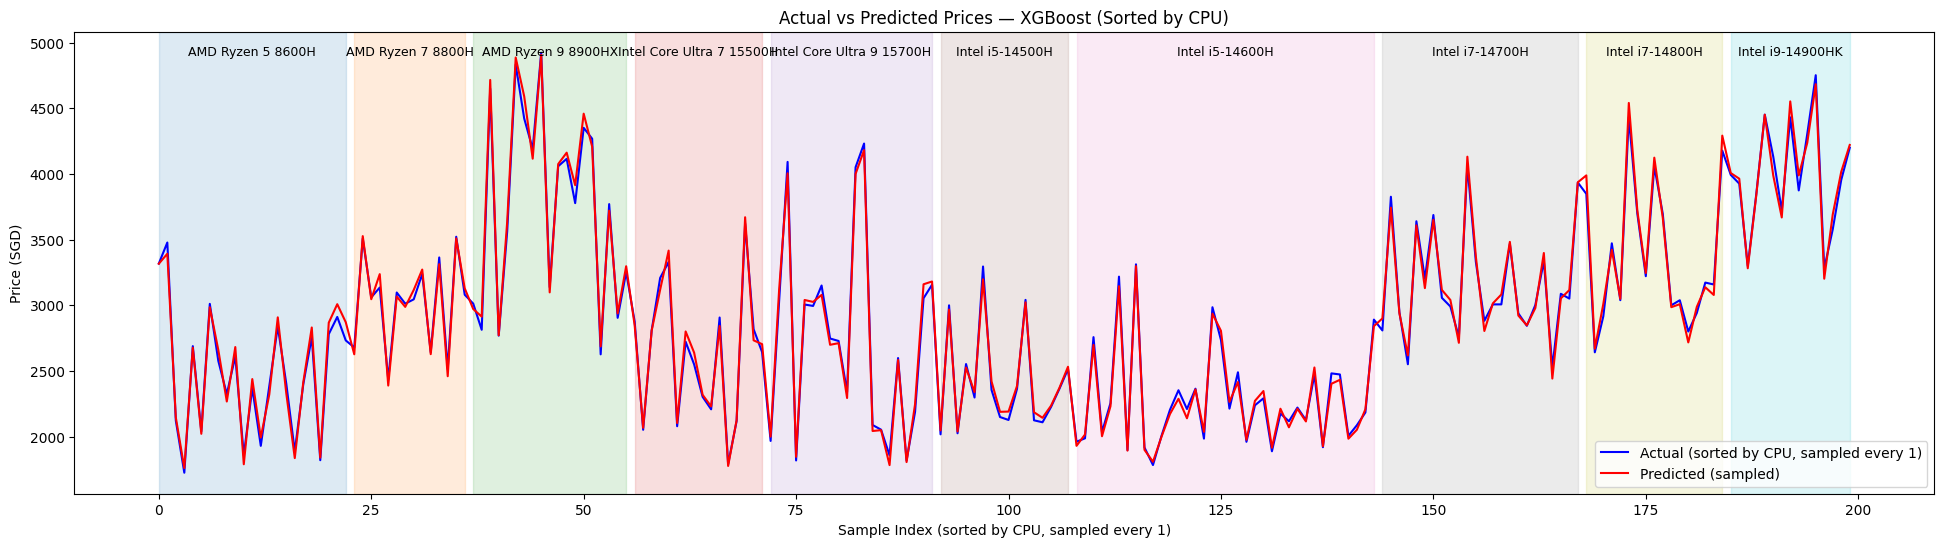

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# USER SETTINGS (edit these only)
# -----------------------------------------
sort_col = "CPU"   # any column in X_test (e.g. "Brand", "GPU", "Screen_Size_inch")
step_n  = 1         # sample every n-th row after sorting

# -----------------------------------------
# 1. Sort by chosen column
# -----------------------------------------
sorted_idx = X_test[sort_col].sort_values().index

X_sorted = X_test.loc[sorted_idx]
y_sorted = y_test.loc[sorted_idx]

# 🔄 XGBoost prediction instead of RF
y_pred_sorted = gs_xgb.best_estimator_.predict(X_sorted)

# Combine into one DataFrame
df_plot = X_sorted.copy()
df_plot["Actual"] = y_sorted.values
df_plot["Predicted"] = y_pred_sorted

# -----------------------------------------
# 2. Apply sampling with iloc[::step_n]
# -----------------------------------------
df_plot = df_plot.iloc[::step_n].reset_index(drop=True)

group_series = df_plot[sort_col]
unique_groups = group_series.unique()

# colour palette based on unique groups
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))

# Find spans for shading
spans = []
start = 0
for i in range(1, len(group_series)):
    if group_series[i] != group_series[i - 1]:
        spans.append((start, i - 1, group_series[i - 1]))
        start = i
spans.append((start, len(group_series) - 1, group_series.iloc[-1]))

# -----------------------------------------
# 3. Plot with shading + sampled lines
# -----------------------------------------
fig, ax = plt.subplots(figsize=(24, 6))

# Background shading (color spelling is correct)
for idx, (s, e, group_name) in enumerate(spans):
    ax.axvspan(s, e, color=colors[idx % len(colors)], alpha=0.15)

# Actual values
ax.plot(
    df_plot["Actual"].values,
    label=f"Actual (sorted by {sort_col}, sampled every {step_n})",
    color="blue"
)

# Predicted values (XGBoost)
ax.plot(
    df_plot["Predicted"].values,
    label="Predicted (sampled)",
    color="red"
)

ax.set_title(f"Actual vs Predicted Prices — XGBoost (Sorted by {sort_col})")
ax.set_xlabel(f"Sample Index (sorted by {sort_col}, sampled every {step_n})")
ax.set_ylabel("Price (SGD)")
ax.legend()

# Group labels
for idx, (s, e, group_name) in enumerate(spans):
    ax.text(
        (s + e) / 2,
        ax.get_ylim()[1] * 0.98,
        str(group_name),
        ha="center",
        va="top",
        fontsize=9
    )

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# USER SETTINGS (edit these only)
# -----------------------------------------
sort_col = "GPU"   # any column in X_test (e.g. "Brand", "GPU", "Screen_Size_inch")
step_n  = 1         # sample every n-th row after sorting

# -----------------------------------------
# 1. Sort by chosen column
# -----------------------------------------
sorted_idx = X_test[sort_col].sort_values().index

X_sorted = X_test.loc[sorted_idx]
y_sorted = y_test.loc[sorted_idx]

# 🔄 XGBoost prediction instead of RF
y_pred_sorted = gs_xgb.best_estimator_.predict(X_sorted)

# Combine into one DataFrame
df_plot = X_sorted.copy()
df_plot["Actual"] = y_sorted.values
df_plot["Predicted"] = y_pred_sorted

# -----------------------------------------
# 2. Apply sampling with iloc[::step_n]
# -----------------------------------------
df_plot = df_plot.iloc[::step_n].reset_index(drop=True)

group_series = df_plot[sort_col]
unique_groups = group_series.unique()

# colour palette based on unique groups
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))

# Find spans for shading
spans = []
start = 0
for i in range(1, len(group_series)):
    if group_series[i] != group_series[i - 1]:
        spans.append((start, i - 1, group_series[i - 1]))
        start = i
spans.append((start, len(group_series) - 1, group_series.iloc[-1]))

# -----------------------------------------
# 3. Plot with shading + sampled lines
# -----------------------------------------
fig, ax = plt.subplots(figsize=(24, 6))

# Background shading (color spelling is correct)
for idx, (s, e, group_name) in enumerate(spans):
    ax.axvspan(s, e, color=colors[idx % len(colors)], alpha=0.15)

# Actual values
ax.plot(
    df_plot["Actual"].values,
    label=f"Actual (sorted by {sort_col}, sampled every {step_n})",
    color="blue"
)

# Predicted values (XGBoost)
ax.plot(
    df_plot["Predicted"].values,
    label="Predicted (sampled)",
    color="red"
)

ax.set_title(f"Actual vs Predicted Prices — XGBoost (Sorted by {sort_col})")
ax.set_xlabel(f"Sample Index (sorted by {sort_col}, sampled every {step_n})")
ax.set_ylabel("Price (SGD)")
ax.legend()

# Group labels
for idx, (s, e, group_name) in enumerate(spans):
    ax.text(
        (s + e) / 2,
        ax.get_ylim()[1] * 0.98,
        str(group_name),
        ha="center",
        va="top",
        fontsize=9
    )

plt.show()


## Chapter 8. Scatter Plot — Actual vs Predicted with Brand Colours

In [ ]:
test_df=X_test.copy()
test_df['Actual']=y_test.values
test_df['Pred_XGB']=gs_xgb.best_estimator_.predict(X_test)
test_df['Error']=test_df['Pred_XGB']-test_df['Actual']
test_df['Brand']=X_test.loc[test_df.index,'Brand']

plt.figure(figsize=(18,6))
for b in test_df['Brand'].unique():
    sb=test_df[test_df['Brand']==b]
    plt.scatter(sb.index,sb['Error'],label=b,alpha=0.7)
plt.axhline(0,color="black",linestyle="--")
plt.title("Prediction Error by Brand — XGB")
plt.xlabel("Sample Index")
plt.ylabel("Error (Predicted - Actual)")
plt.ylim(-500,500)
plt.legend()
plt.show()


In [ ]:
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.figure(figsize=(10,8))
sns.scatterplot(x=test_df['Actual'],y=test_df['Pred_XGB'],hue=test_df['Brand'],alpha=0.8)
plt.plot([test_df['Actual'].min(),test_df['Actual'].max()],
         [test_df['Actual'].min(),test_df['Actual'].max()],
         '--',color='black')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted by Brand — XGB")
plt.show()


## Chapter 9. Ask LLM to Interpret All Results

###Activity
Draft your own prompt, including all relevant context, to ask for advice on how to improve feature engineering.
A sample solution is provided below. Attempt this on your own first before scrolling down to compare.

In [ ]:
df_all = X_test.copy()

df_all["Actual"] = y_test.values
df_all["Predicted"] = xgb_model.predict(X_test)

df_all["Error"] = df_all["Predicted"] - df_all["Actual"]
df_all["Abs_Error"] = df_all["Error"].abs()

summary_rows = []

for col in cat_columns:
    grp = (
        df_all
        .groupby(col)
        .agg(
            actual_mean=("Actual", "mean"),
            actual_std=("Actual", "std"),
            error_mean=("Error", "mean"),
            error_std=("Error", "std"),
            abs_error_mean=("Abs_Error", "mean"),
            abs_error_std=("Abs_Error", "std"),
            count=("Error", "size")
        )
        .reset_index()
    )

    grp.insert(0, "grouping_column", col)
    grp.rename(columns={col: "group_value"}, inplace=True)

    summary_rows.append(grp)
summary_df = pd.concat(summary_rows, ignore_index=True)
summary_df_text = summary_df.to_string()
summary_df


In [ ]:
summary_df_text

In [ ]:
pd.DataFrame(results).T.to_string()

In [ ]:
Brand_map={'Acer': 1300, 'HP': 1450, 'Lenovo': 1600, 'Microsoft': 2200, 'Dell': 2000, 'Asus': 1800}
Model_map={'TravelMate P6': 1500, 'Pavilion 15': 1199, 'Legion 5': 1899, 'Envy 13': 1600, 'Surface Laptop 5': 2499, 'Aspire 5': 899, 'Inspiron 15': 899, 'IdeaPad 5': 899, 'Surface Book 3': 2899, 'ThinkBook 14s': 1299, 'ROG Zephyrus G15': 2799, 'Yoga Slim 7': 1399, 'ExpertBook B9': 2399, 'ZenBook 14': 1599, 'Surface Pro 8': 1399, 'Predator Helios 300': 1999, 'Surface Laptop Studio': 3299, 'Nitro 5': 1199, 'Omen 15': 1899, 'Surface Go 3': 649, 'XPS 15': 3199, 'VivoBook S15': 899, 'XPS 13': 1999, 'Swift 3': 999, 'Latitude 7420': 2199, 'TUF Gaming F15': 1299, 'Alienware M15': 3499, 'EliteBook 840': 2199, 'Spectre x360': 1799, 'ThinkPad X1 Carbon': 2599}
CPU_map={'Intel Core Ultra 7 15500H': 2600, 'Intel i5-14600H': 1500, 'Intel i7-14700H': 2200, 'Intel i9-14900HK': 4000, 'Intel i5-14500H': 1400, 'Intel i7-14800H': 2700, 'AMD Ryzen 7 8800H': 2300, 'AMD Ryzen 9 8900HX': 3200, 'AMD Ryzen 5 8600H': 1300, 'Intel Core Ultra 9 15700H': 4200}
GPU_map={'NVIDIA RTX 4070': 2800, 'NVIDIA RTX 4050': 1600, 'NVIDIA RTX 4060': 2100, 'NVIDIA RTX 3050': 1200, 'Intel Arc A750M': 1500, 'Intel Iris Xe': 1100, 'NVIDIA RTX 4080': 3800, 'AMD Radeon 780M': 1200, 'AMD Radeon 680M': 1400}
import json
maps_text = json.dumps(
    {"Brand_map": Brand_map, "Model_map": Model_map, "CPU_map": CPU_map, "GPU_map": GPU_map},
    indent=2,
    ensure_ascii=False
)

In [ ]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Use ONLY the information inside the dataset profile text.
Do NOT invent correlations, columns, or values.
If something is not in the dataset profile, state 'Not shown in profile'.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f'''
Advise on I can improve my feature engineering and encoding method. \n
Model performance:
{pd.DataFrame(results).T.to_string()} \n
Prediction quality:
{summary_df_text} \n
Current encoding mapping:
{maps_text}
''')

print(response.output_text)
